#### **Importing the necessary Libraries**

In [1]:
import os
import glob
import h5py
import scipy
import matplotlib.pyplot as plt

import random
import numpy as np
from PIL import Image
import cv2
from typing import Tuple,List,Dict,Callable
from datetime import datetime

#### **Creating a Custom Data Folder**

In [2]:
import torch
from torch.utils.data import Dataset

In [3]:
class CustomImageFolder(Dataset):
    
    '''
    A custom dataset class for loading images and their corresponding labels
    
    Args:
        list_image_paths (List[str]):List of file paths to the images.
        image_transform (Callable, optional): A function/transform to apply to the images.
        label_transform (Callable, optional): A function/transform to apply to the labels.
    '''
    
    
    def __init__(self, list_image_paths: List[str], image_transform: Callable = None,label_transform: Callable = None):
        
        self.image_paths = list_image_paths
        self.image_transform = image_transform
        self.label_transform = label_transform
        
    def __len__(self) -> int:
        
        '''Returns the total no of samples'''
        return len(self.image_paths)
    
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        '''
        Load and return the image and its label from the given index.
        
        Args:
            index (int): Index of the sample to be feteched
            
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: A tuple containing the transformed image and label as tensors.
        '''
        
        img_path = self.image_paths[index]
        
        try:
            img,label = load_data(img_path)
            
        except Exception as e:
            raise RuntimeError(f'Error loading data from {img_path}:{e}')
            
        if self.image_transform is not None:
            img = self.image_transform(img)
            
        if self.label_transform is not None:
            label = self.label_transform(label)
            
        return img, label

#### **Load the images and apply data transformation on targets**

In [4]:
def load_data(img_path) ->Tuple[Image.Image,np.ndarray]:
    
    '''
    Load an image and its corresponding ground truth density map, then resize the density map.
    
    Args:
        img_path (str or pathlib.Path): Path to the image file.
        
    Returns:
        image (Image.Image): Loaded image.
        final_gt (np.ndarray): Resized density map adjusted to maintain the original count.
    '''
    
    gt_path = img_path.replace('.jpg','.h5').replace('images','ground-truth-h5')
    
#     print(f'Ground Truth Path:{gt_path}')
    
    try:
        
        with h5py.File(gt_path,'r') as gt_file:
            
            gt_image = np.asarray(gt_file['density'])
            
    except Exception as e:
        
        raise FileNotFoundError(f'Error loading ground truth file: {e}')
        
    target_shape = (int(gt_image.shape[1]/8),int(gt_image.shape[0]/8))
    
    org_gt_count = np.sum(gt_image)
    
    resized_gt = cv2.resize(gt_image,target_shape,interpolation=cv2.INTER_CUBIC)
    resized_gt_count = np.sum(resized_gt)
    
    
    if org_gt_count != resized_gt_count:
        
        adjust_ratio = org_gt_count / resized_gt_count
        final_gt = resized_gt * adjust_ratio
        
    else:
        
        final_gt = resized_gt
        
    try:
        original_image = Image.open(img_path).convert('RGB')
        
    except Exception as e:
        
        raise FileNotFoundError(f'Error loading image file: {e}')
        
    return original_image, final_gt
        

#### **Creating the list_of_image_paths**

In [5]:
def load_images(base_folder: str, train_path: str, test_path: str) -> Tuple[List[str], List[str]]:
    '''
    Load all image paths from the train and test directories
    
    Args:
        base_folder (str): part of data (part_A or part_B)
        train_path (str): training data folder name
        test_path (str): testing data folder name
        
    Returns:
        train_paths (List[str]): list of the train paths
        test_paths (List[str]): list of the test paths
    '''
    
    root_dir = '/kaggle/input'
 
    dataset_path = os.path.join(root_dir, 'shanghaitech-with-people-density-map/ShanghaiTech')
    
    train_paths, test_paths = [], []
    
    if base_folder == 'part_A': 
        if train_path == 'train_data':
            paths = os.path.join(dataset_path, base_folder, train_path, 'images')
            train_paths = glob.glob(os.path.join(paths, '*.jpg'))
        
        if test_path == 'test_data':
            paths = os.path.join(dataset_path, base_folder, test_path, 'images')
            test_paths = glob.glob(os.path.join(paths, '*.jpg'))

    elif base_folder == 'part_B': 
        if train_path == 'train_data':
            paths = os.path.join(dataset_path, base_folder, train_path, 'images')
            train_paths = glob.glob(os.path.join(paths, '*.jpg'))
        
        if test_path == 'test_data':
            paths = os.path.join(dataset_path, base_folder, test_path, 'images')
            test_paths = glob.glob(os.path.join(paths, '*.jpg'))
            
    print(f'Image paths base folder {base_folder} - train: {len(train_paths)} | test: {len(test_paths)}')
    
    if not train_paths and not test_paths:
        raise ValueError("Both train and test lists are empty") 
        
    if not train_paths:
        raise ValueError("The train list is empty")
        
    if not test_paths:
        raise ValueError("The test list is empty")

    return train_paths, test_paths

#### **Initialization of the Data Folder**

In [6]:
from torchvision import transforms

In [7]:
base_folder, train_path, test_path = 'part_B', 'train_data', 'test_data'
train_paths, test_paths = load_images(base_folder, train_path, test_path)


image_data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])


label_data_transform = transforms.Compose([
        transforms.ToTensor()
    
])

train_dataset = CustomImageFolder(train_paths, image_data_transform,label_data_transform)
test_dataset = CustomImageFolder(test_paths,image_data_transform,label_data_transform)

Image paths base folder part_B - train: 400 | test: 316


In [8]:
# train_paths

In [9]:
# train dataset
print(f'Type of the dataset:{type(train_dataset)}')

Type of the dataset:<class '__main__.CustomImageFolder'>


In [10]:
#First Sample of train_dataset
img,label = train_dataset[0]
img,label

(tensor([[[ 0.1254,  0.6906,  1.0844,  ...,  2.2489,  2.2489,  1.6838],
          [ 0.5193,  0.9132,  1.1529,  ...,  2.2489,  2.1975,  1.3070],
          [ 0.4851,  0.7591,  1.0159,  ...,  2.1975,  1.6667,  0.6392],
          ...,
          [ 0.2453,  0.2796,  0.2967,  ...,  0.6392,  0.5364,  0.5707],
          [ 0.2967,  0.2624,  0.3138,  ...,  0.6906,  0.6563,  0.7419],
          [ 0.3652,  0.2796,  0.3481,  ...,  0.6221,  0.6392,  0.7591]],
 
         [[ 0.2227,  0.8354,  1.2381,  ...,  2.2010,  2.1835,  1.4132],
          [ 0.6254,  1.0630,  1.3431,  ...,  2.1835,  1.9384,  1.0280],
          [ 0.6254,  0.9230,  1.1856,  ...,  1.9559,  1.3782,  0.3102],
          ...,
          [ 0.2577,  0.2927,  0.3102,  ...,  0.6429,  0.5378,  0.5728],
          [ 0.3102,  0.2752,  0.3277,  ...,  0.6954,  0.6604,  0.7479],
          [ 0.3803,  0.2927,  0.3627,  ...,  0.6254,  0.6429,  0.7654]],
 
         [[ 0.4614,  1.0539,  1.4548,  ...,  1.1934,  1.2282,  0.4614],
          [ 0.8622,  1.2805,

#### **Data Loaders**

In [11]:
from  torch.utils.data import DataLoader

In [12]:
train_dataloader = DataLoader(dataset=train_dataset,
          batch_size=2,
          shuffle=True,
          num_workers=os.cpu_count(),
          pin_memory=True)

test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=2,
                            shuffle=False,
                            num_workers=os.cpu_count(),
                            pin_memory=True)

#### **Exploring the dataloaders**

##### **checking the data type of the train loaders**

In [13]:
batch_image, batch_label = next(iter(train_dataloader))

In [14]:
# Check data type of the first element in the dataloader
print(f'Data Type of first:{type(batch_image)}')

Data Type of first:<class 'torch.Tensor'>


In [15]:
# Check data type of the first element's tensor in the dataloader
data_type = batch_image.dtype
print("Data type of first batch (using dtype):", data_type)

Data type of first batch (using dtype): torch.float32


In [16]:
# Check if the data is a PyTorch tensor
is_tensor = isinstance(batch_image, torch.Tensor)
print("Is first batch element a PyTorch tensor:", is_tensor)

Is first batch element a PyTorch tensor: True


In [17]:
for image,label in train_dataloader:
    print(image.shape,label.shape)
    break

torch.Size([2, 3, 768, 1024]) torch.Size([2, 1, 96, 128])


#### **Visualizing the model**

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def display_random_batch_images(dataloader, batch_image, batch_label, figsize=(10, 5), num_images=5, seed_no=None):
    """Displays a random subset of images and their corresponding labels, fetching additional batches if needed.

    Args:
        dataloader (torch.utils.data.DataLoader): The DataLoader to fetch additional batches.
        batch_image (torch.Tensor): Current batch of images with shape (batch_size, C, H, W).
        batch_label (torch.Tensor): Current batch of labels with shape (batch_size, ...).
        figsize (tuple, optional): Size of the figure to be displayed. Defaults to (10, 5).
        num_images (int, optional): Number of images to display. Defaults to 5.
        seed_no (int, optional): Random seed for reproducibility.
    """
    
    if seed_no:
        np.random.seed(seed_no)

    # Accumulate images and labels
    images_list = [batch_image]
    labels_list = [batch_label]
    
    # Keep fetching batches if current batch size is less than num_images
    total_images = len(batch_image)
    data_iter = iter(dataloader)  # Create an iterator for the dataloader
    
    while total_images < num_images:
        try:
            # Fetch next batch from the dataloader
            next_batch_image, next_batch_label = next(data_iter)
            images_list.append(next_batch_image)
            labels_list.append(next_batch_label)
            total_images += len(next_batch_image)
        except StopIteration:
            print("Reached the end of the DataLoader, not enough images to display the requested amount.")
            break

    # Stack all batches together
    batch_image = torch.cat(images_list, dim=0)
    batch_label = torch.cat(labels_list, dim=0)

    # Ensure num_images doesn't exceed the total number of accumulated images
    num_images = min(num_images, total_images)

    # Select random indices to display
    random_indexes = np.random.choice(total_images, size=num_images, replace=False)

    # Create a figure with subplots for each image
    fig, axes = plt.subplots(num_images, 2, figsize=(figsize[0], num_images * figsize[1]))

    for i, index in enumerate(random_indexes):
        # Get the image and label from the concatenated batch
        image = batch_image[index].permute(1, 2, 0)  # Convert (C, H, W) to (H, W, C)
        label = batch_label[index].permute(1, 2, 0)  # Convert (C, H, W) to (H, W, C)

        # Display image
        axes[i][0].imshow(image)
        axes[i][0].set_title(f"Original Image \nSize: {image.shape}")
        axes[i][0].axis("off")

        # Display label
        axes[i][1].imshow(label)
        # Set title for label with number of people
        num_people = torch.sum(label).item()  # Convert to Python number
        axes[i][1].set_title(f"Target Image \nNo of People: {num_people:.0f} \nSize: {label.shape}")
        axes[i][1].axis("off")


    plt.tight_layout()
    plt.show()

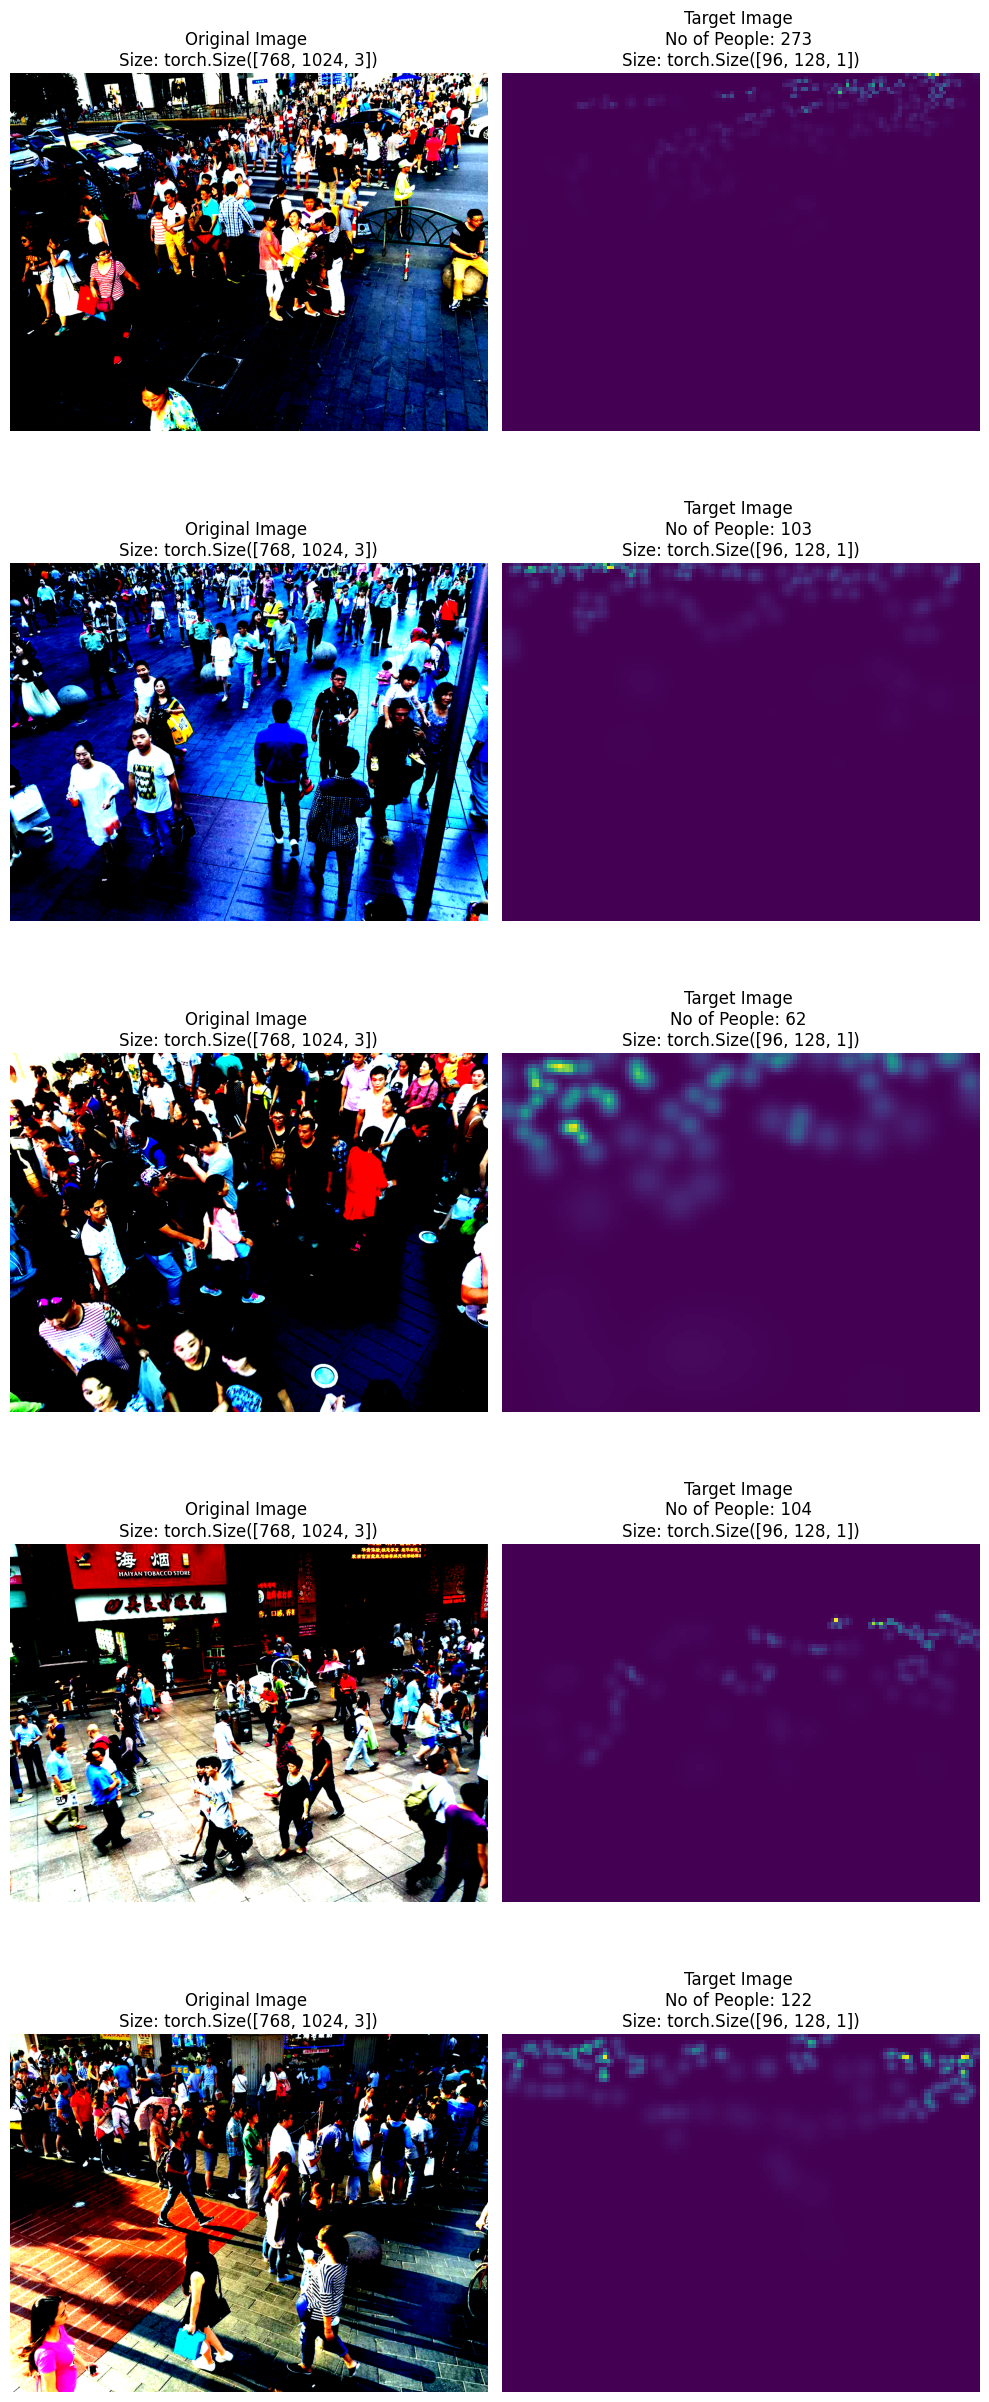

In [19]:
for batch_image, batch_label in train_dataloader:
    display_random_batch_images(train_dataloader, batch_image, batch_label, num_images=5, seed_no=42)
    break  

#### **Building a Model**

In [20]:
#setup the device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### **Importing the necessary Libraries**

In [21]:
import torchvision
from torchvision import models
from torchinfo import summary
from torch import nn

#### **Loading the pretrained VGG16 model**

In [22]:
# Get a set of pretrained model weights

# WEIGHTS = torchvision.models.VGG16_Weights.DEFAULT
# model = torchvision.models.vgg16(weights=WEIGHTS).to(device)
# model

In [23]:
# for name,module in model.named_children():
#     if isinstance(module,nn.Sequential):
#         print(f'module {module}')
#         for sub_name, sub_module in module.named_children():
#             if isinstance(sub_module,nn.Conv2d):
#                 print(f'Module:{sub_name} {sub_module}')
#                 print(f'Weights shape:{sub_module.weight.data.shape}')

In [24]:
# nn.Sequential(*list(model.features.children())[:10])

In [25]:
# # Print a summary using torchinfo (uncomment for actual output)
# summary(model=model, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# ) 

#### **Building the Model Architecture**

In [26]:
class CSRNet(nn.Module):
    
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat = [512, 512, 512, 256, 128, 64]
        
        self.frontend = make_layers(self.frontend_feat, in_channels=3, dilation=False)
        self.backend = make_layers(self.backend_feat, in_channels=512, dilation=True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        
        if not load_weights:
            
            # Load VGG16 with a progress bar
            weights = torchvision.models.VGG16_Weights.DEFAULT  # Pretrained weights on ImageNet
            vgg16_model = torchvision.models.vgg16(weights=weights, progress=True).to(device)  # progress=True enables the download progress bar
            
            self._initialize_weights()
            # Load weights into frontend layers
            for i, (name, module) in enumerate(self.frontend.named_children()):
                if isinstance(module, nn.Conv2d):
                    module.weight.data[:] = vgg16_model.features[i].weight.data[:]
                    if module.bias is not None:
                        module.bias.data[:] = vgg16_model.features[i].bias.data[:]
                
    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
                
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                nn.init.constant_(m.bias, 0)

def make_layers(cfg, in_channels=3, dilation=False):
    layers = []
    d_rate = 2 if dilation else 1
    
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    
    return nn.Sequential(*layers)

In [27]:
#Initialize the model
torch.manual_seed(42)
csrnet_model = CSRNet()
csrnet_model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 198MB/s]  


CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

#### **checking the model parameters data type**

In [28]:
csrnet_model = csrnet_model
# Check data type of a model parameter (e.g., the first layer's weights)
first_layer_weights = next(iter(csrnet_model.parameters()))
param_type = type(first_layer_weights)
print("Data type of model parameter:", param_type)

Data type of model parameter: <class 'torch.nn.parameter.Parameter'>


In [29]:
# Check data type of a model parameter's tensor
param_type = first_layer_weights.dtype
print("Data type of model parameter (using dtype):", param_type)

Data type of model parameter (using dtype): torch.float32


#### **Model Summary**

In [30]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=csrnet_model, 
        input_size=(1, 3, 768, 768), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
        col_names=["input_size", "output_size", "num_params"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                  Input Shape          Output Shape         Param #
CSRNet (CSRNet)                          [1, 3, 768, 768]     [1, 1, 96, 96]       --
├─Sequential (frontend)                  [1, 3, 768, 768]     [1, 512, 96, 96]     --
│    └─Conv2d (0)                        [1, 3, 768, 768]     [1, 64, 768, 768]    1,792
│    └─ReLU (1)                          [1, 64, 768, 768]    [1, 64, 768, 768]    --
│    └─Conv2d (2)                        [1, 64, 768, 768]    [1, 64, 768, 768]    36,928
│    └─ReLU (3)                          [1, 64, 768, 768]    [1, 64, 768, 768]    --
│    └─MaxPool2d (4)                     [1, 64, 768, 768]    [1, 64, 384, 384]    --
│    └─Conv2d (5)                        [1, 64, 384, 384]    [1, 128, 384, 384]   73,856
│    └─ReLU (6)                          [1, 128, 384, 384]   [1, 128, 384, 384]   --
│    └─Conv2d (7)                        [1, 128, 384, 384]   [1, 128, 384, 384]   147,584
│    └─ReLU (8)                  

#### **Checking the with sample input**

In [31]:
x = torch.rand(2,3,768,1024).to(device)
x.shape,x.dtype,x.device

(torch.Size([2, 3, 768, 1024]), torch.float32, device(type='cuda', index=0))

#### **Checking the sample output**

In [32]:
out_put = csrnet_model(x)
out_put.shape

torch.Size([2, 1, 96, 128])

In [33]:
out_put

tensor([[[[-1.3647e-04, -4.6251e-05, -9.1654e-05,  ...,  8.9471e-06,
            2.8804e-06, -4.4013e-06],
          [-1.2191e-04, -6.4633e-05, -3.8803e-05,  ...,  2.5877e-05,
            1.0004e-05,  2.4416e-05],
          [-1.0278e-04, -4.4791e-05, -1.3279e-04,  ...,  1.6800e-05,
            9.9342e-05,  1.1571e-04],
          ...,
          [-1.2807e-04, -8.3431e-05, -1.3191e-04,  ..., -4.4098e-05,
            2.9645e-05,  3.6827e-05],
          [-2.3597e-06, -2.3899e-05, -4.2145e-05,  ...,  2.5631e-05,
            3.3208e-05,  4.0225e-05],
          [ 1.9970e-06, -1.8614e-05, -1.3516e-04,  ..., -2.0761e-05,
            9.4190e-06,  1.1236e-05]]],


        [[[-1.4865e-04, -1.0500e-04, -4.3341e-05,  ..., -5.4099e-05,
            2.1228e-05,  5.2642e-05],
          [-1.2128e-04, -7.0684e-05, -7.2949e-06,  ...,  2.8062e-05,
            2.9673e-05,  2.7490e-05],
          [-1.1126e-04, -9.6318e-05, -1.2555e-04,  ...,  1.3000e-04,
            9.3657e-05,  9.8753e-05],
          ...,
   

#### **Make Predictions with the untrained Model**

In [34]:
batch = next(iter(test_dataloader))
batch_image,batch_label = batch

In [35]:
len(batch)

2

In [36]:
batch_image.shape,batch_label.shape

(torch.Size([2, 3, 768, 1024]), torch.Size([2, 1, 96, 128]))

In [37]:
batch_image[0].shape

torch.Size([3, 768, 1024])

In [38]:
# Make predictions with the model
untrained_preds = csrnet_model(batch_image[0].unsqueeze(dim=0).to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(batch_label[0])}, Shape: {batch_label[0].shape}")
print(f"\nFirst 1 predictions:\n{untrained_preds}")
print(f"\nFirst 1 test labels:\n{batch_label}")

untrained_preds.detach().to('cpu') == batch_label.unsqueeze(dim=0).to('cpu')

Length of predictions: 1, Shape: torch.Size([1, 1, 96, 128])
Length of test samples: 1, Shape: torch.Size([1, 96, 128])

First 1 predictions:
tensor([[[[-2.6729e-04, -1.9338e-04, -3.8175e-05,  ...,  9.8031e-05,
            6.4270e-05,  8.8612e-05],
          [-3.6307e-04, -3.2010e-04, -1.1775e-04,  ...,  2.2694e-04,
            5.2066e-05, -5.1653e-06],
          [-3.6029e-04, -2.5123e-04, -2.9274e-04,  ...,  2.1021e-04,
            2.8667e-04,  1.9554e-04],
          ...,
          [-8.8416e-05, -1.9432e-04, -8.2079e-05,  ..., -2.3839e-05,
            3.8831e-05,  8.8655e-05],
          [-1.1294e-05, -6.8278e-05,  5.3106e-05,  ...,  8.4810e-05,
            2.2828e-05,  1.4285e-04],
          [-2.1698e-04, -5.5578e-05, -1.2947e-05,  ..., -4.0800e-05,
            2.2225e-05,  5.4041e-05]]]], device='cuda:0',
       grad_fn=<ConvolutionBackward0>)

First 1 test labels:
tensor([[[[1.7014e-03, 1.8539e-02, 8.2378e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.3684e-

tensor([[[[[False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           ...,
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False]]],


         [[[False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           ...,
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False]]]]])

#### **Custom Loss Function(Research Paper)**
                                            N              GT 2 
       1. Eculidean Distance - L(Θ) = 1/2N ∑  ‖Z(Xi; Θ) − Z ‖2
                                           i=1            i

In [39]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, Z_pred, Z_GT):
        """
        Compute the custom loss as described in the research paper.

        Parameters:
        - Z_pred: Predicted density map tensor (batch_size, channels, height, width)
        - Z_GT: Ground truth density map tensor (batch_size, channels, height, width)

        Returns:
        - loss: Scalar tensor containing the averaged custom loss.
        """
        batch_size = Z_pred.size(0)
        
        # Calculate squared L2 norm
        squared_norm = torch.sum((Z_pred - Z_GT)**2) 
        
        # Compute the custom loss
        loss = squared_norm / (2 * batch_size)
        
        return loss

In [40]:
loss_fn = CustomLoss()

In [41]:
untrained_preds.shape

torch.Size([1, 1, 96, 128])

In [42]:
Z_pred = untrained_preds.detach().to('cpu')
Z_GT = batch_label[0].unsqueeze(dim=0)
Z_pred.device,Z_GT.device

(device(type='cpu'), device(type='cpu'))

In [43]:
# Calculate loss
loss = loss_fn(Z_pred, Z_GT)
print('Custom Loss:', loss.item())

Custom Loss: 5.901157379150391


#### **Optimizer SGD**

In [44]:
optimizer = torch.optim.SGD(params=csrnet_model.parameters(),
                           lr=1e-4)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

#### **Accuracy** 
 - There are indeed evaluation metrics that are commonly used to assess the performance of crowd counting models. These metrics help quantify how well the predicted density maps match the ground truth density maps.

#### **Mean Absolute Error (MAE) and Mean Squared Error (MSE)**

In [45]:
def mean_absolute_error(y_pred, y_true):
    return torch.mean(torch.abs(y_pred - y_true))

def mean_squared_error(y_pred, y_true):
    return torch.mean((y_pred - y_true)**2)

#### **Peak Signal-to-Noise Ratio (PSNR)**

In [46]:
def psnr(y_pred, y_true, max_pixel_value=1.0):
    mse = mean_squared_error(y_pred, y_true)
    psnr = 10 * torch.log10((max_pixel_value ** 2) / mse)
    return psnr

#### **Structural Similarity Index (SSIM)**

In [47]:
from torchmetrics.image import StructuralSimilarityIndexMeasure

# Initialize the SSIM metric
ssim = StructuralSimilarityIndexMeasure(data_range=1.0)


### **Train the model**

In [48]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [49]:
def check_for_nan(tensor):
    """ Check if there are NaNs in the given tensor """
    return torch.isnan(tensor).any().item() if tensor is not None else False

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               mean_absolute_error,
               mean_squared_error,
               psnr,
               ssim,
               device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    
    train_loss, train_mae, train_mse, train_psnr, train_ssim = 0, 0, 0, 0, 0
    model.to(device)
    
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        
        train_loss += loss.item()
        train_mae += mean_absolute_error(y_pred, y).item()
        train_mse += mean_squared_error(y_pred, y).item()
        train_psnr += psnr(y_pred.cpu(), y.cpu().clone(), max_pixel_value=1.0).item()
        train_ssim += ssim(y_pred.cpu(), y.cpu().clone()).item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()
        
        # Check for NaNs in intermediate layers
        for name, layer in model.named_modules():  # No need for .module here
            if hasattr(layer, 'weight') and check_for_nan(layer.weight):
                print(f"Found NaNs in layer: {name} at iteration {batch}")
                return  # Stop training if NaNs are found
            
            if hasattr(layer, 'bias') and check_for_nan(layer.bias):
                print(f"Found NaNs in layer: {name} at iteration {batch}")
                return  # Stop training if NaNs are found   
            
        # Gradient clipping (optional)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_mae /= len(data_loader)
    train_mse /= len(data_loader)
    train_psnr /= len(data_loader)
    train_ssim /= len(data_loader)
    
    return train_loss, train_mae, train_mse, train_psnr, train_ssim

In [50]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              mean_absolute_error,
              mean_squared_error,
              psnr,
              ssim,
              device: torch.device = device):
    
    test_loss, test_mae, test_mse, test_psnr, test_ssim = 0, 0, 0, 0, 0
    
    model.to(device)
    
    model.eval() # put model in eval mode
    
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y).item()
            test_mae += mean_absolute_error(test_pred,y).item()
            test_mse += mean_squared_error(test_pred,y).item()
            test_psnr += psnr(test_pred.cpu(),y.cpu().clone(),max_pixel_value=1.0).item()
            test_ssim += ssim(test_pred.cpu(),y.cpu().clone()).item()
        
    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_mae /= len(data_loader)
    test_mse /= len(data_loader)
    test_psnr /= len(data_loader)
    test_ssim /= len(data_loader)
    
    return test_loss,test_mae,test_mse,test_psnr,test_ssim

In [51]:
from timeit import default_timer as timer
from datetime import datetime

def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device (torch.device, optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    start_datetime = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    end_datetime = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    print(f"Training started at: {start_datetime}")
    print(f"Training ended at: {end_datetime}")
    
    if device:
        print(f"Train time on {device}: {total_time:.3f} seconds ({total_time/60:.3f} minutes)")
    else:
        print(f"Train time: {total_time:.3f} seconds ({total_time/60:.3f} minutes)")
    
    return total_time

# Example usage:
# start_time = timer()
# start_datetime = datetime.now()
# # simulate some training process
# end_time = timer()
# end_datetime = datetime.now()
# print_train_time(start_time, end_time, device="cpu")

#### **Save the check points**

In [52]:
# Save the model, optimizer state, epoch, and results
def save_checkpoint(model, optimizer, epoch, results, filename="checkpoint.pth.tar"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'results': results
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch+1}")

# Load checkpoint to resume training
def load_checkpoint(model, optimizer, filename="checkpoint.pth.tar"):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    results = checkpoint['results']
    print(f"Checkpoint loaded: Resuming from epoch {epoch+1}")
    return epoch, results

In [53]:
import torch
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm

# Define your save_checkpoint and load_checkpoint functions here

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          mean_absolute_error,
          mean_squared_error,
          psnr,
          ssim,
          epochs: int = 50,
          device='cuda' if torch.cuda.is_available() else 'cpu',
          log_graph=False,
          checkpoint_path="/kaggle/working/checkpoint.pth.tar"):  # Default path to Kaggle working directory
    
    # Move model to device
    model.to(device)
    
    # Initialize the SummaryWriter
    writer = SummaryWriter()

    # Try loading a saved checkpoint
    start_epoch = 0
    results = {"train_loss": [], "train_mae": [], "train_mse": [], "train_psnr": [], "train_ssim": [],
               "test_loss": [], "test_mae": [], "test_mse": [], "test_psnr": [], "test_ssim": []}
    
    try:
        start_epoch, results = load_checkpoint(model, optimizer, checkpoint_path)
    except FileNotFoundError:
        print("No checkpoint found, starting training from scratch.")

    # Training loop
    for epoch in tqdm(range(start_epoch, epochs)):

        # Perform a training step
        train_loss, train_mae, train_mse, train_psnr, train_ssim = train_step(
            data_loader=train_dataloader, 
            model=model, 
            loss_fn=loss_fn,
            optimizer=optimizer,
            mean_absolute_error=mean_absolute_error,
            mean_squared_error=mean_squared_error,
            psnr=psnr,
            ssim=ssim,
            device=device)

        # Perform a test step
        test_loss, test_mae, test_mse, test_psnr, test_ssim = test_step(
            data_loader=test_dataloader,
            model=model,
            loss_fn=loss_fn,
            mean_absolute_error=mean_absolute_error,
            mean_squared_error=mean_squared_error,
            psnr=psnr,
            ssim=ssim,
            device=device)

        # Print out the epoch results
        print(f"Epoch: {epoch+1} | "
              f"Train loss: {train_loss:.5f} | "
              f"Train MAE: {train_mae:.5f} | "
              f"Train MSE: {train_mse:.5f} | "
              f"Train PSNR: {train_psnr:.5f} | "
              f"Train SSIM: {train_ssim:.5f}")
              
        print(f"Test loss: {test_loss:.5f} | "
              f"Test MAE: {test_mae:.5f} | "
              f"Test MSE: {test_mse:.5f} | "
              f"Test PSNR: {test_psnr:.5f} | "
              f"Test SSIM: {test_ssim:.5f}\n")

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_mae"].append(train_mae)
        results["train_mse"].append(train_mse)
        results["train_psnr"].append(train_psnr)
        results["train_ssim"].append(train_ssim)

        results["test_loss"].append(test_loss)
        results["test_mae"].append(test_mae)
        results["test_mse"].append(test_mse)
        results["test_psnr"].append(test_psnr)
        results["test_ssim"].append(test_ssim)
        
        ### TensorBoard Logging ###
        # Log losses
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Log MAE, MSE, PSNR, and SSIM in TensorBoard
        writer.add_scalars(main_tag="MAE", 
                           tag_scalar_dict={"train_mae": train_mae,
                                            "test_mae": test_mae}, 
                           global_step=epoch)

        writer.add_scalars(main_tag="MSE", 
                           tag_scalar_dict={"train_mse": train_mse,
                                            "test_mse": test_mse}, 
                           global_step=epoch)

        writer.add_scalars(main_tag="PSNR", 
                           tag_scalar_dict={"train_psnr": train_psnr,
                                            "test_psnr": test_psnr}, 
                           global_step=epoch)

        writer.add_scalars(main_tag="SSIM", 
                           tag_scalar_dict={"train_ssim": train_ssim,
                                            "test_ssim": test_ssim}, 
                           global_step=epoch)
        
        # Track the PyTorch model architecture on the first epoch (if log_graph is True)
        if log_graph and epoch == 0:
            example_input = next(iter(train_dataloader))[0].to(device)
            writer.add_graph(model, input_to_model=example_input)

        # Save checkpoint every 4 epochs
        if (epoch + 1) % 4 == 0:
            save_checkpoint(model, optimizer, epoch, results, filename=checkpoint_path)

    # Close the writer at the end of training
    writer.close()
    
    return results

In [54]:
# import torch
# from torch.utils.tensorboard import SummaryWriter
# from tqdm.auto import tqdm

# # Define or import your mean_absolute_error, mean_squared_error, psnr, and ssim functions here

# # Define your train_step and test_step functions here

# # 1. Take in various parameters required for training and test steps
# def train(model: torch.nn.Module, 
#           train_dataloader: torch.utils.data.DataLoader, 
#           test_dataloader: torch.utils.data.DataLoader, 
#           optimizer: torch.optim.Optimizer,
#           loss_fn: torch.nn.Module,
#           mean_absolute_error,
#           mean_squared_error,
#           psnr,
#           ssim,
#           epochs: int = 50,
#           device='cuda' if torch.cuda.is_available() else 'cpu',
#           log_graph=False):
    
#     # Move model to device
#     model.to(device)
    
#     # Initialize the SummaryWriter
#     writer = SummaryWriter()

#     results = {"train_loss":[],"train_mae":[],"train_mse":[],"train_psnr":[],"train_ssim":[],
#               "test_loss":[],"test_mae":[],"test_mse":[],"test_psnr":[],"test_ssim":[]}

#     for epoch in tqdm(range(epochs)):

#         # Perform a training step
#         train_loss, train_mae, train_mse, train_psnr, train_ssim = train_step(
#                         data_loader=train_dataloader, 
#                         model=model, 
#                         loss_fn=loss_fn,
#                         optimizer=optimizer,
#                         mean_absolute_error=mean_absolute_error,
#                         mean_squared_error=mean_squared_error,
#                         psnr=psnr,
#                         ssim=ssim,
#                         device=device)


#         # Perform a test step
#         test_loss, test_mae, test_mse, test_psnr, test_ssim = test_step(
#                         data_loader=test_dataloader,
#                         model=model,
#                         loss_fn=loss_fn,
#                         mean_absolute_error=mean_absolute_error,
#                         mean_squared_error=mean_squared_error,
#                         psnr=psnr,
#                         ssim=ssim,
#                         device=device)

#         # Print out the epoch results
#         print(f"Epoch: {epoch+1} | "
#               f"Train loss: {train_loss:.5f} | "
#               f"Train MAE: {train_mae:.5f} | "
#               f"Train MSE: {train_mse:.5f} | "
#               f"Train PSNR: {train_psnr:.5f} | "
#               f"Train SSIM: {train_ssim:.5f}")
              
#         print(f"Test loss: {test_loss:.5f} | "
#               f"Test MAE: {test_mae:.5f} | "
#               f"Test MSE: {test_mse:.5f} | "
#               f"Test PSNR: {test_psnr:.5f} | "
#               f"Test SSIM: {test_ssim:.5f}\n")

#         # Update results dictionary
#         results["train_loss"].append(train_loss)
#         results["train_mae"].append(train_mae)
#         results["train_mse"].append(train_mse)
#         results["train_psnr"].append(train_psnr)
#         results["train_ssim"].append(train_ssim)

#         results["test_loss"].append(test_loss)
#         results["test_mae"].append(test_mae)
#         results["test_mse"].append(test_mse)
#         results["test_psnr"].append(test_psnr)
#         results["test_ssim"].append(test_ssim)
        
        
#         ### TensorBoard Logging ###
        
#         # Log losses
#         writer.add_scalars(main_tag="Loss", 
#                            tag_scalar_dict={"train_loss": train_loss,
#                                             "test_loss": test_loss},
#                            global_step=epoch)

#         # Log MAE
#         writer.add_scalars(main_tag="MAE", 
#                            tag_scalar_dict={"train_mae": train_mae,
#                                             "test_mae": test_mae}, 
#                            global_step=epoch)

#         # Log MSE
#         writer.add_scalars(main_tag="MSE", 
#                            tag_scalar_dict={"train_mse": train_mse,
#                                             "test_mse": test_mse}, 
#                            global_step=epoch)
        
#         # Log PSNR
#         writer.add_scalars(main_tag="PSNR", 
#                            tag_scalar_dict={"train_psnr": train_psnr,
#                                             "test_psnr": test_psnr}, 
#                            global_step=epoch)
        
#         # Log SSIM
#         writer.add_scalars(main_tag="SSIM", 
#                            tag_scalar_dict={"train_ssim": train_ssim,
#                                             "test_ssim": test_ssim}, 
#                            global_step=epoch)
        
#         # Track the PyTorch model architecture on the first epoch (if log_graph is True)
#         if log_graph and epoch == 0:
#             example_input = next(iter(train_dataloader))[0].to(device)
#             writer.add_graph(model, input_to_model=example_input)  # Only add model graph

#     # Close the writer at the end of training
#     writer.close()
    
#     return results

In [55]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# loss function initialization and optimizer

loss_fn = CustomLoss()
optimizer = optimizer

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# # Train model_0 
# model_0_results = train(model=csrnet_model, 
#                         train_dataloader=train_dataloader,
#                         test_dataloader=test_dataloader,
#                         optimizer=optimizer,
#                         loss_fn=loss_fn, 
#                         mean_absolute_error=mean_absolute_error,
#                         mean_squared_error=mean_squared_error,
#                         psnr=psnr,
#                         ssim=ssim,
#                         epochs=NUM_EPOCHS,
#                        device=device,
#                        log_graph=True)


# Path to the uploaded checkpoint
checkpoint_path = '/kaggle/working/checkpoint.pth.tar'

# Call the train function and it will resume from the last checkpoint
model_0_results = train(model=csrnet_model, 
                train_dataloader=train_dataloader, 
                test_dataloader=test_dataloader, 
                optimizer=optimizer,
                loss_fn=loss_fn,
                mean_absolute_error=mean_absolute_error,
                mean_squared_error=mean_squared_error,
                psnr=psnr,
                ssim=ssim,
                epochs=NUM_EPOCHS,  # This is the total number of epochs you plan to train
                device=device,
                checkpoint_path=checkpoint_path)  # Specify the path to the checkpoint

# End the timer and print out how long it took
end_time = timer()
total_time_model_train = print_train_time(start=start_time, end=end_time, device=device)
total_time_model_train

No checkpoint found, starting training from scratch.


/tmp/ipykernel_37/1039448437.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


  0%|          | 0/10 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | Train loss: 24.60407 | Train MAE: 0.01216 | Train MSE: 0.00400 | Train PSNR: 28.65305 | Train SSIM: 0.73658
Test loss: 22.04661 | Test MAE: 0.01347 | Test MSE: 0.00359 | Test PSNR: 28.46647 | Test SSIM: 0.66529

Epoch: 2 | Train loss: 24.48296 | Train MAE: 0.01373 | Train MSE: 0.00398 | Train PSNR: 28.10838 | Train SSIM: 0.65156
Test loss: 22.04335 | Test MAE: 0.01344 | Test MSE: 0.00359 | Test PSNR: 28.47106 | Test SSIM: 0.66718

Epoch: 3 | Train loss: 24.47589 | Train MAE: 0.01379 | Train MSE: 0.00398 | Train PSNR: 28.15642 | Train SSIM: 0.64867
Test loss: 22.02910 | Test MAE: 0.01387 | Test MSE: 0.00359 | Test PSNR: 28.44088 | Test SSIM: 0.64281

Epoch: 4 | Train loss: 24.46861 | Train MAE: 0.01408 | Train MSE: 0.00398 | Train PSNR: 28.11953 | Train SSIM: 0.63233
Test loss: 22.02004 | Test MAE: 0.01425 | Test MSE: 0.00358 | Test PSNR: 28.41168 | Test SSIM: 0.62230

Checkpoint saved at epoch 4
Epoch: 5 | Train loss: 24.46871 | Train MAE: 0.01386 | Train MSE: 0.00398 | Trai

2351.043201239

#### **Plot the curves**

In [56]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {
                "train_loss": [...],
                "train_mae": [...],
                "train_mse": [...],
                "train_psnr": [...],
                "train_ssim": [...],
                "test_loss": [...],
                "test_mae": [...],
                "test_mse": [...],
                "test_psnr": [...],
                "test_ssim": [...]
            }
    """
    
    metrics = {
        'Loss': ('train_loss', 'test_loss'),
        'Mean Absolute Error (MAE)': ('train_mae', 'test_mae'),
        'Mean Squared Error (MSE)': ('train_mse', 'test_mse'),
        'Peak Signal-to-Noise Ratio (PSNR)': ('train_psnr', 'test_psnr'),
        'Structural Similarity Index (SSIM)': ('train_ssim', 'test_ssim')
    }

    # Determine the number of subplots based on the number of metrics
    num_metrics = len(metrics)
    fig, axes = plt.subplots(num_metrics, 1, figsize=(15, num_metrics * 5))

    # If there's only one metric, `axes` is not a list, so we need to make it a list for consistency
    if num_metrics == 1:
        axes = [axes]

    for ax, (metric_name, (train_key, test_key)) in zip(axes, metrics.items()):
        epochs = range(len(results[train_key]))
        train_values = results[train_key]
        test_values = results[test_key]

        ax.plot(epochs, train_values, label=f'Train {metric_name.lower()}')
        ax.plot(epochs, test_values, label=f'Test {metric_name.lower()}')
        ax.set_title(f'{metric_name} over Epochs')
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric_name)
        ax.legend()

    plt.tight_layout()
    plt.show()

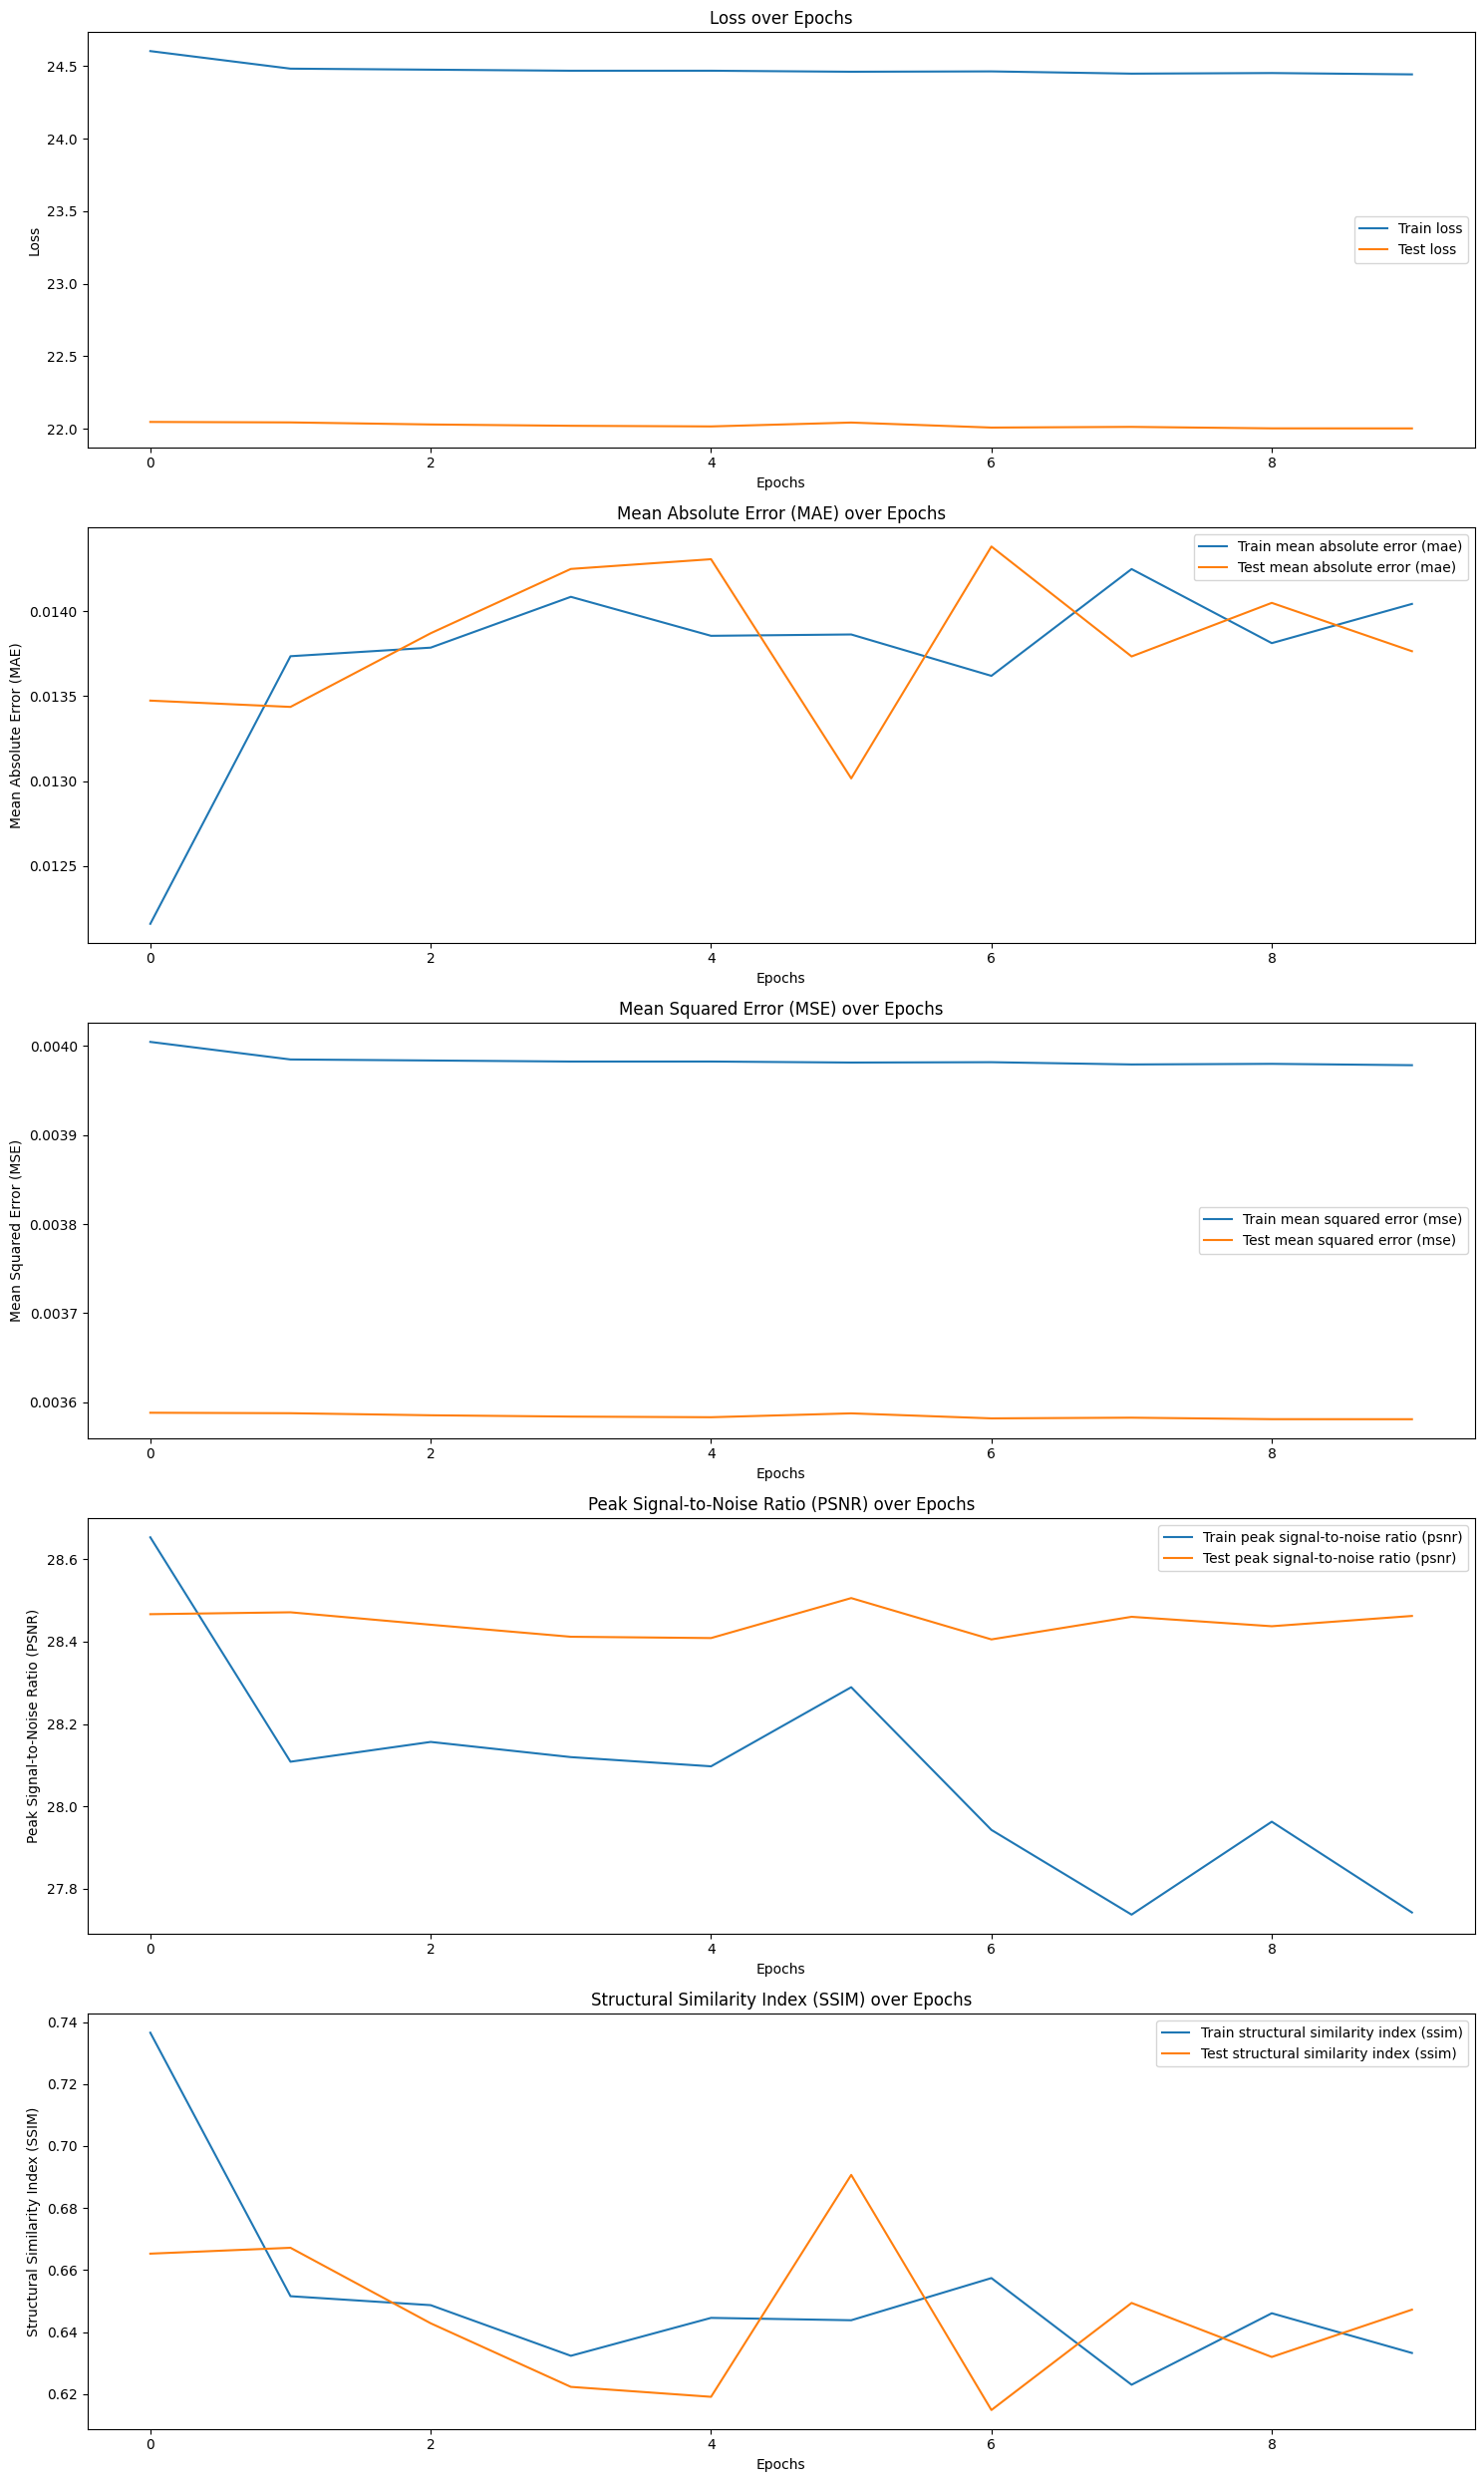

In [57]:
plot_loss_curves(model_0_results)

#### **Model Save Path**

In [58]:
from pathlib import Path

In [59]:
os.getcwd()

'/kaggle/working'

In [60]:
# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

In [61]:
model_to_save = csrnet_model

In [62]:
# 2. Create model save path 
MODEL_NAME = "01_csrnet_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_to_save.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/01_csrnet_model_1.pth


### **Inferencing the trained model** 

In [63]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
csrnet_model_1 = CSRNet()
csrnet_model_1.to(device)

CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [64]:
# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
csrnet_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

/tmp/ipykernel_37/2013386769.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  csrnet_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

### **Inference the trained model**

In [65]:
def pred_and_plot_images(model: torch.nn.Module, 
                         image_paths,
                         image_data_transform=None,
                         label_data_transform=None,
                         density_map_label=None,
                         device: torch.device = torch.device('cpu')):
    """Makes predictions on a list of target images and plots each image with its prediction."""
    
    num_images = len(image_paths)
    
    random.shuffle(image_paths)
    
    # Make sure the model is on the target device
    model.to(device)
    model.eval()
    
    # Calculate the number of rows and columns for the grid
    num_cols = 3  # Target Image, Actual Density Map, Predicted Density Map
    num_rows = num_images
    
    # Setup the plot
    plt.figure(figsize=(18, 6 * num_rows))
    
    for idx in range(num_images):
        # Load and transform the target image
        target_image = Image.open(image_paths[idx]).convert('RGB')
        if image_data_transform:
            target_image = image_data_transform(target_image)
        
        # Load and transform the actual density map
        actual_dmap = density_map_label(image_paths[idx])
        if label_data_transform:
            actual_dmap = label_data_transform(actual_dmap)
        
        # Perform prediction
        with torch.no_grad():
            target_image = target_image.unsqueeze(dim=0).to(device)
            target_image_pred = model(target_image)
            target_image_pred = target_image_pred.squeeze(dim=0).cpu()
        
        # Plot target image
        plt.subplot(num_rows, num_cols, idx * num_cols + 1)
        plt.imshow(target_image.squeeze().permute(1, 2, 0).cpu().numpy())
        plt.title(f"Target Image-{target_image.shape}")
        plt.axis('off')

        # Plot actual density map
        plt.subplot(num_rows, num_cols, idx * num_cols + 2)
        plt.imshow(actual_dmap.squeeze().cpu().numpy(), cmap='viridis')
        plt.title(f"Actual Density Map - {torch.round(torch.sum(actual_dmap))}")
        plt.axis('off')

        # Plot predicted density map
        plt.subplot(num_rows, num_cols, idx * num_cols + 3)
        plt.imshow(target_image_pred.squeeze().cpu().numpy(), cmap='viridis')
        plt.title(f"Predicted Density Map - {torch.round(torch.sum(target_image_pred))}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [66]:
image_data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

label_data_transform = transforms.Compose([
        transforms.ToTensor()
    
])

In [67]:
def density_map_label(density_map_path):
    
    gt_path = density_map_path.replace('jpg','h5').replace('images','ground-truth-h5')
    with h5py.File(gt_path,'r') as File:
        gt_image = np.asarray(File['density'])
        
    target_shape = (int(gt_image.shape[1] / 8), int(gt_image.shape[0] / 8))
    original_gt_count = np.sum(gt_image)
    resized_gt = cv2.resize(gt_image, target_shape, interpolation=cv2.INTER_CUBIC)
    resized_gt_count = np.sum(resized_gt)

    if original_gt_count != resized_gt_count:
        adjust_ratio = original_gt_count / resized_gt_count
        final_gt = resized_gt * adjust_ratio
    else:
        final_gt = resized_gt
    
    return final_gt

Image paths base folder part_A - train: 300 | test: 182


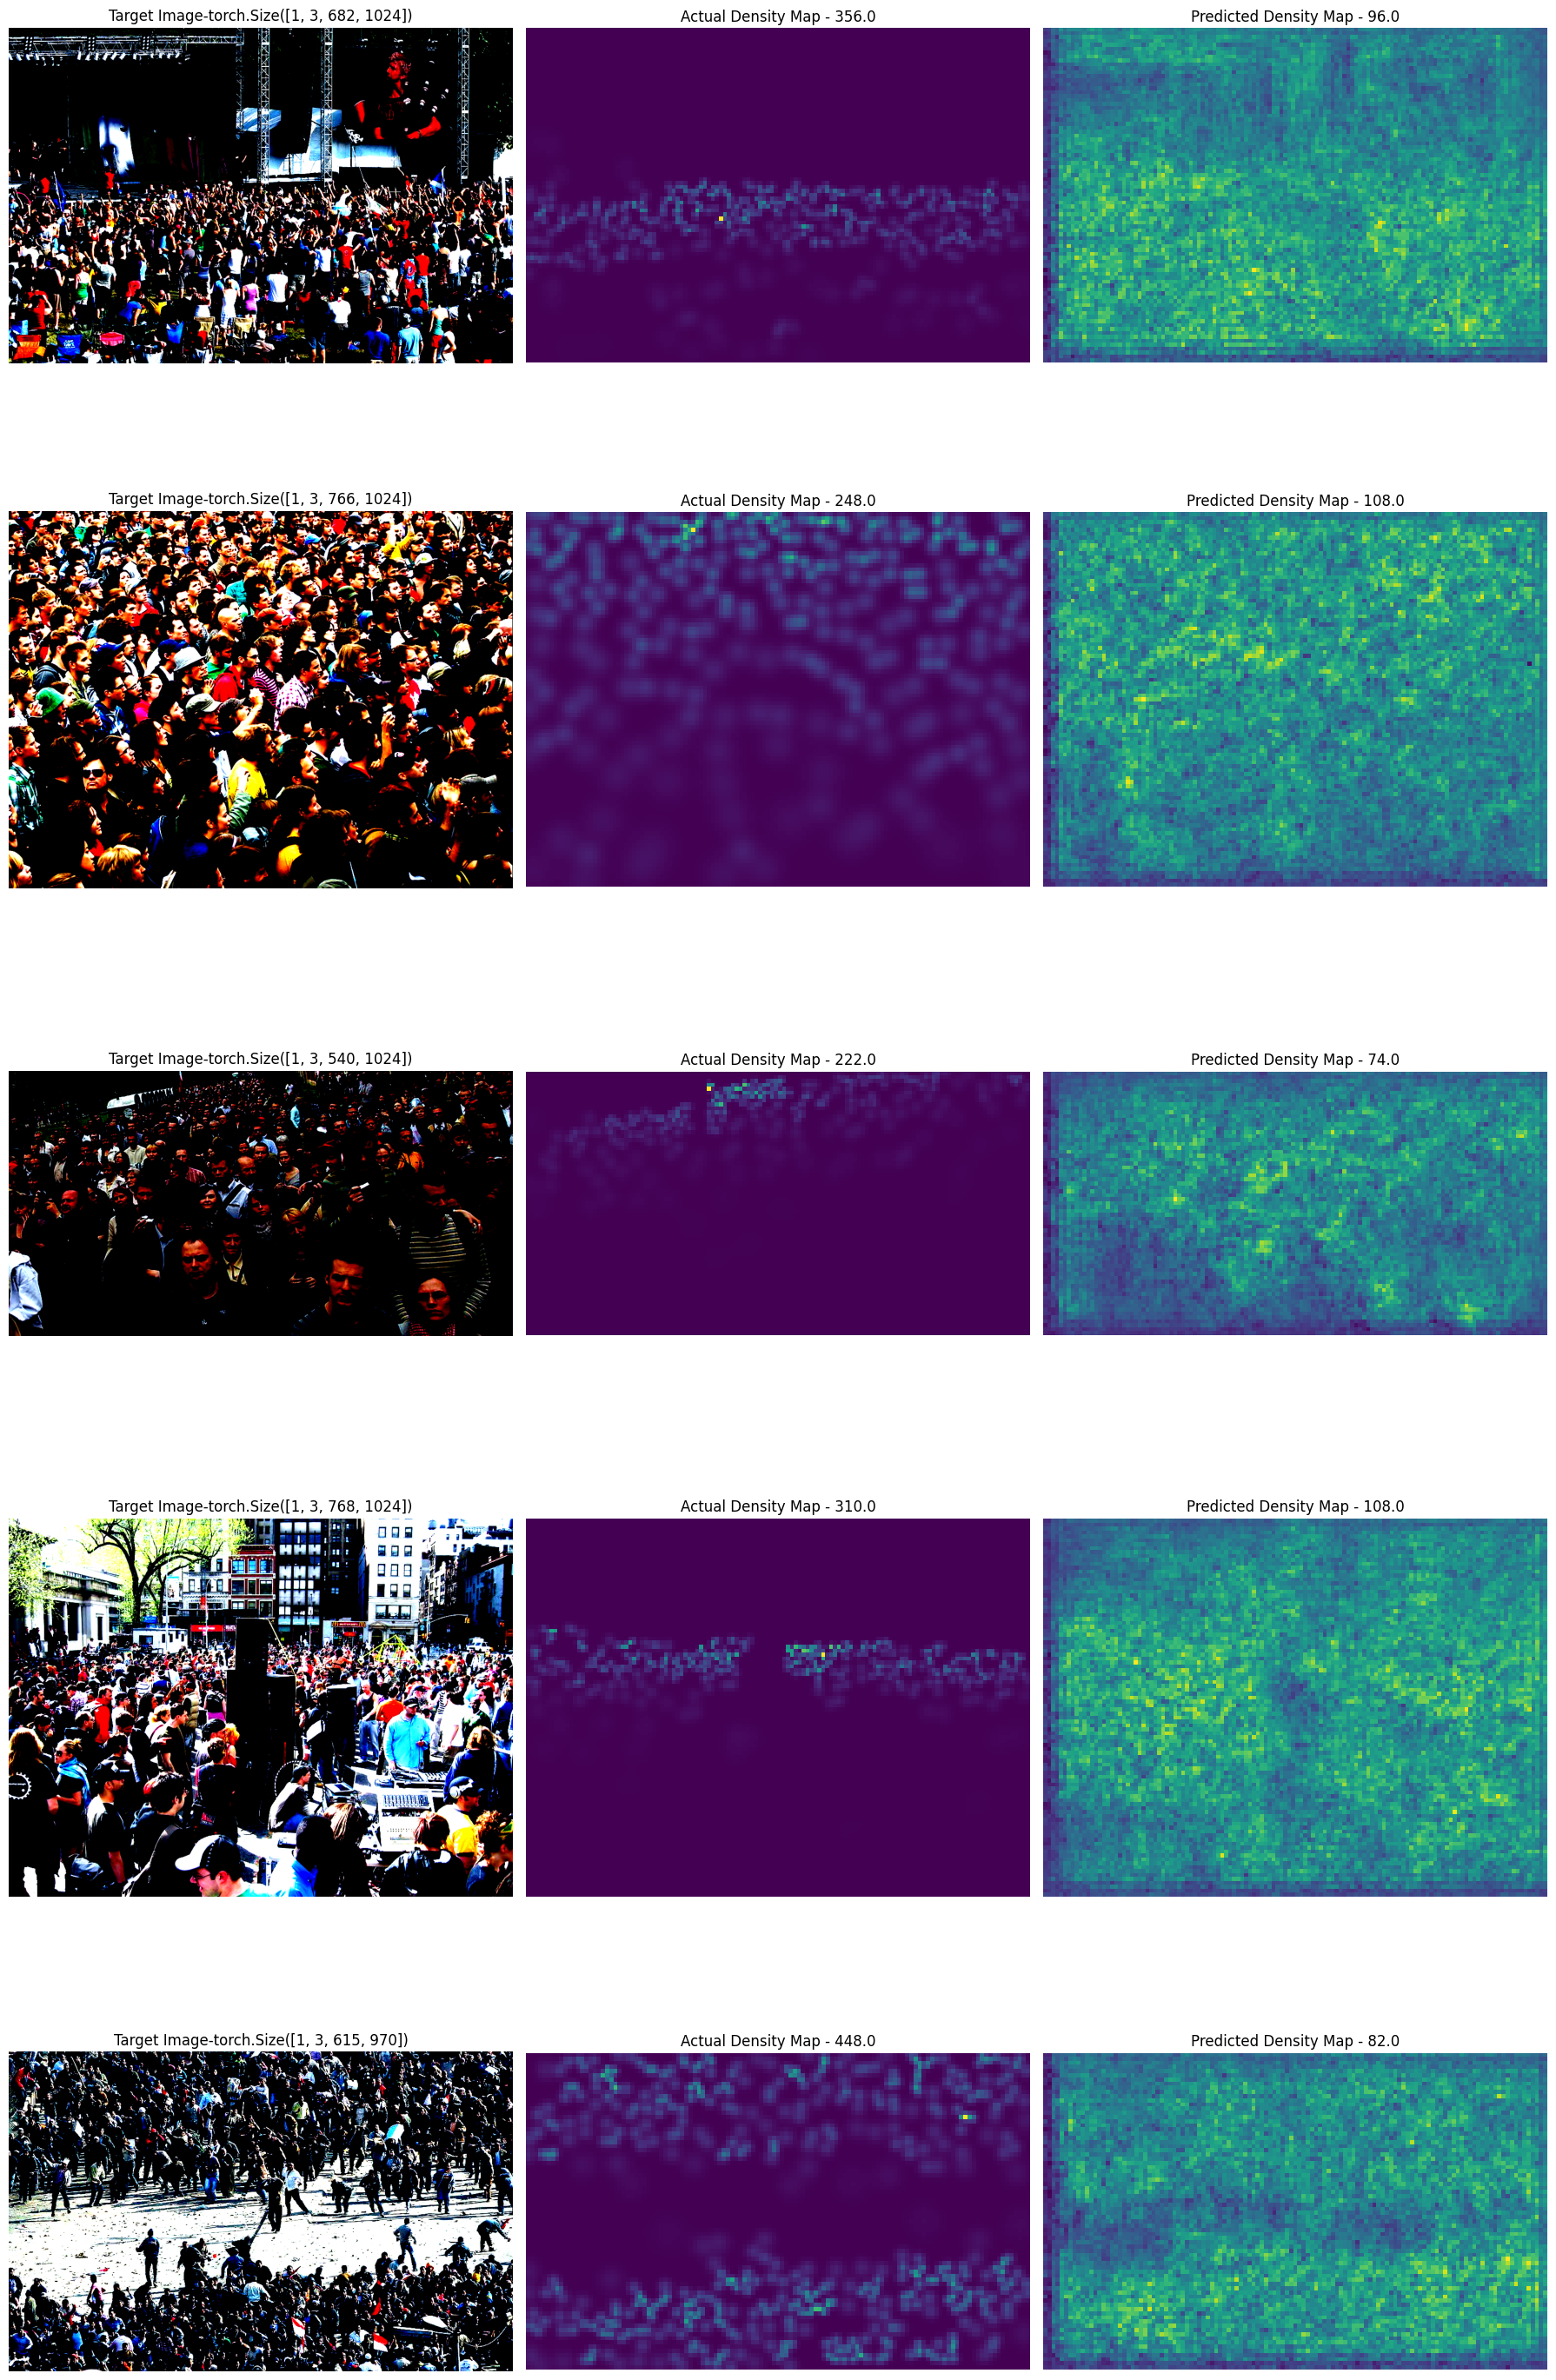

In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
eval_train_paths, eval_test_paths = load_images(base_folder='part_A', train_path='train_data', test_path='test_data')

# Pred on our custom image
pred_and_plot_images(model=csrnet_model_1,
                     image_paths=eval_train_paths[:5],
                     image_data_transform=image_data_transform,
                     label_data_transform=label_data_transform,
                     density_map_label=density_map_label,
                     device=device)